# Find weather stations that set flags
From the AWS data catalog of station data, find the subset of weather stations that set flags 
<br>Output a DataFrame

## 0. Setup 
Read in required libraries and create temporary data directory

In [1]:
import xarray as xr 
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import s3fs
import tempfile # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point
import time # Used for progress bar 
import sys # Used for progress bar 

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Warning is raised when creating Point object from coords. Can't figure out why. 

In [2]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary 
temp_dir = "./tmp"
if not os.path.exists(temp_dir): 
    os.mkdir(temp_dir)

## 1. Define some helper functions

In [3]:
def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.6+
    """
    Print a progress bar to console 

    References
    ----------
    https://stackoverflow.com/questions/3160699/python-progress-bar
    
    """
    count = len(it)
    start = time.time() # time estimate start
    def show(j):
        x = int(size*j/count)
        # time estimate calculation and string
        remaining = ((time.time() - start) / j) * (count - j)        
        mins, sec = divmod(remaining, 60) # limited to minutes
        time_str = f"{int(mins):02}:{sec:03.1f}"
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count} Est wait {time_str}", end='\r', file=out, flush=True)
    show(0.1) # avoid div/0 
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

In [4]:
def read_nc_from_s3(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket 

    Parameters
    ----------
    network_name: str 
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")
    
    Returns 
    -------
    station_data: xr.Dataset 
    
    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file 
    I'd like to see us use a zarr workflow if possible to avoid this. 

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir = temp_dir, 
        prefix = "", 
        suffix = ".nc",
        delete = True
    )

    # Create s3 file system 
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = 's3://wecc-historical-wx/3_qaqc_wx_dev/{}/{}.nc'.format(network_name, station_id)

    # Read in the data using xarray 
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine='h5netcdf').load()

    # Close temporary file 
    temp_file.close()

    return station_data 

In [5]:
def find_flags(station_ds): 
    """Find unique flags in a Dataset.
    Filters through flag variables; assumes flag variables contain the substring '_eraqc'

    Parameters
    ----------
    station_ds: xr.Dataset 
        Dataset containing station data, with each variable as a unique data variable 
    
    Returns 
    -------
    unique_flags: list or None
        List of unique flag values found in station_ds 
        Returns None if no flags found for any variable 
    
    """

    # Get the string names of the eraqc flag variables 
    era_flag_var_names = [var for var in station_ds.data_vars if '_eraqc' in var]

    # Subset Dataset to just contain flag variables 
    station_flags_ds = station_ds[era_flag_var_names]

    # Check for nulls in the flag variables 
    # If all are null, that means the station set no flags for this event! 
    all_null = station_flags_ds.to_array().isnull().all().item()
    unique_flags = None

    # If there are some flags set, find out what they are 
    if not all_null: 
        # Stack all the variables, since we don't care which variables the flags belong to 
        # Makes it easier to search the array (fewer lines of code :)
        # Works like np.flatten, but on an xarray object 
        stacked = station_flags_ds.to_array().stack({"everything":["variable","time"]})

        # Drop all non-null values 
        # i.e. [nan, nan, 23, nan, 17] --> [23, 17]
        all_flags = stacked.where(~stacked.isnull(), drop=True)

        # Get unique flag values as integers
        # nan is treated as a float so the .isnull() step converted floats to ints (I think)
        # i.e. [23.0, 23.0, 23.0, 17.0, 23.0, 19.0, 19.0] --> [23, 17, 19]
        unique_flags = list(np.unique(all_flags.values).astype(int))

    return unique_flags

## 2. Read in county shapefile and station metadata csv
County shapefile is used for getting event geometry <br>Station metadata is used to get the station ids to read in station data from the S3 bucket

In [6]:
# Read in a list of weather stations 
# We just use the names of the stations to filter 
# Ideally I'd like to see this moved to the AWS bucket 
train_stns = pd.read_csv('../qaqc_training_station_list.csv')

# Create new geometry column from lat and lon columns 
# This will enable us to filter through the GeoDataFrame using our county geometry
train_stns = gpd.GeoDataFrame(
    train_stns, geometry=gpd.points_from_xy(train_stns.longitude, train_stns.latitude, crs="EPSG:4326")
)
#train_stns.head()

In [7]:
# Read in county shapefiles from S3
ca_counties = gpd.read_file("s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp")
ca_counties = ca_counties.to_crs(train_stns.crs) # Convert to station CRS 
#ca_counties.head()

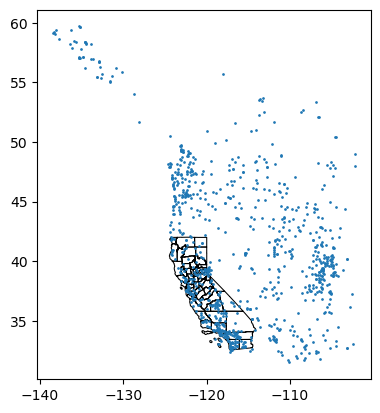

In [8]:
# Plot all the stations and all the counties 
# This is a check to ensure both have the same projection
fig, ax = plt.subplots()
ca_counties.boundary.plot(color="black",ax=ax,linewidth=0.75,zorder=10)
train_stns.geometry.plot(markersize=0.9,ax=ax,zorder=15);

## 3. Set your event date and (optional) event geometry
For example, lets use the Montecito mudslide from January 5-9, 2018

In [9]:
event_start_date = "2018-01-01" # Start a few days before the mudslide
event_end_date = "2018-01-09"

event_geom = ca_counties[ca_counties["NAME"] == "Santa Barbara"] # Get event geometry

## 4. Get the stations that intersect the event geometry

In [10]:
train_stns["intersects"] = train_stns.intersects(event_geom.unary_union) # See which stations intersect with the event polygon
event_stns = train_stns[train_stns["intersects"]==True].reset_index(drop=True) # Get just those stations, drop the others 
event_stns

,era-id,elevation,network,longitude,latitude,geometry,intersects
0,CNRFC_TCTC1,2900.0,CNRFC,-119.908800,34.520800,POINT (-119.90880 34.52080),True
1,CWOP_C7260,430.0,CWOP,-120.422670,34.884000,POINT (-120.42267 34.88400),True
2,CNRFC_ECIC1,3458.0,CNRFC,-119.637500,34.482780,POINT (-119.63750 34.48278),True
3,CWOP_AV377,3970.0,CWOP,-119.713170,34.494670,POINT (-119.71317 34.49467),True
4,CIMIS_76,160.0,CIMIS,-120.512000,34.924000,POINT (-120.51200 34.92400),True
5,CIMIS_88,2192.0,CIMIS,-119.673800,34.942525,POINT (-119.67380 34.94253),True
6,RAWS_SBIC1,360.0,RAWS,-119.030322,33.487428,POINT (-119.03032 33.48743),True
7,CAHYDRO_MAZC1,2571.0,CAHYDRO,-120.083300,34.900000,POINT (-120.08330 34.90000),True
8,CWOP_AP900,3917.0,CWOP,-120.040000,35.049200,POINT (-120.04000 35.04920),True
9,CIMIS_38,270.0,CIMIS,-120.384000,34.954000,POINT (-120.38400 34.95400),True


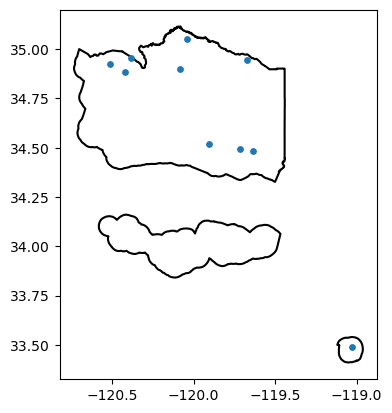

In [11]:
# Make a plot to visualize the stations and event poly
fig, ax = plt.subplots()
event_geom.boundary.plot(color="black",ax=ax, zorder=10)
event_stns.geometry.plot(markersize=15,ax=ax,zorder=15);

## 5. Filter through stations to see if flags were set

In [12]:
# Flags, network, and station ID will be stored here
# Dictionary can be easily convered to a DataFrame and output as a csv 
stations_with_flags = {"network":[],"era-id":[],"flags":[]}

# Loop through each station to look for flags 
for i in progressbar(range(len(event_stns))):
    
    # Get info for one station 
    network_name, station_id = event_stns.iloc[i][["network","era-id"]]

    # Read in the data from AWS as an xarray Dataset 
    station_ds = read_nc_from_s3(
        network_name=network_name, 
        station_id=station_id, 
        temp_dir=temp_dir
        )

    # Reduce dimension of object 
    # "station" is a singleton dimension
    station_ds = station_ds.squeeze()

    # Subset Dataset to event time period 
    station_ds = station_ds.sel(time=slice(event_start_date, event_end_date))

    # Look for flags 
    # If no flags found, find_flags returns None
    unique_flags = find_flags(station_ds)

    # If flags are found, save them to the dictionary
    if unique_flags is not None: 
        stations_with_flags["network"].append(network_name) 
        stations_with_flags["era-id"].append(station_id)
        stations_with_flags["flags"].append(unique_flags)

[████████████████████████████████████████████████████████████] 10/10 Est wait 00:0.00



In [ ]:
# Output a DataFrame
# I don't record which variables these flags belong to... does that matter? 
stations_with_flags_df = pd.DataFrame(stations_with_flags)
stations_with_flags_df

,network,era-id,flags
0,CIMIS,CIMIS_88,[23]
1,RAWS,RAWS_SBIC1,[13]
